# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


In [3]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [5]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [6]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

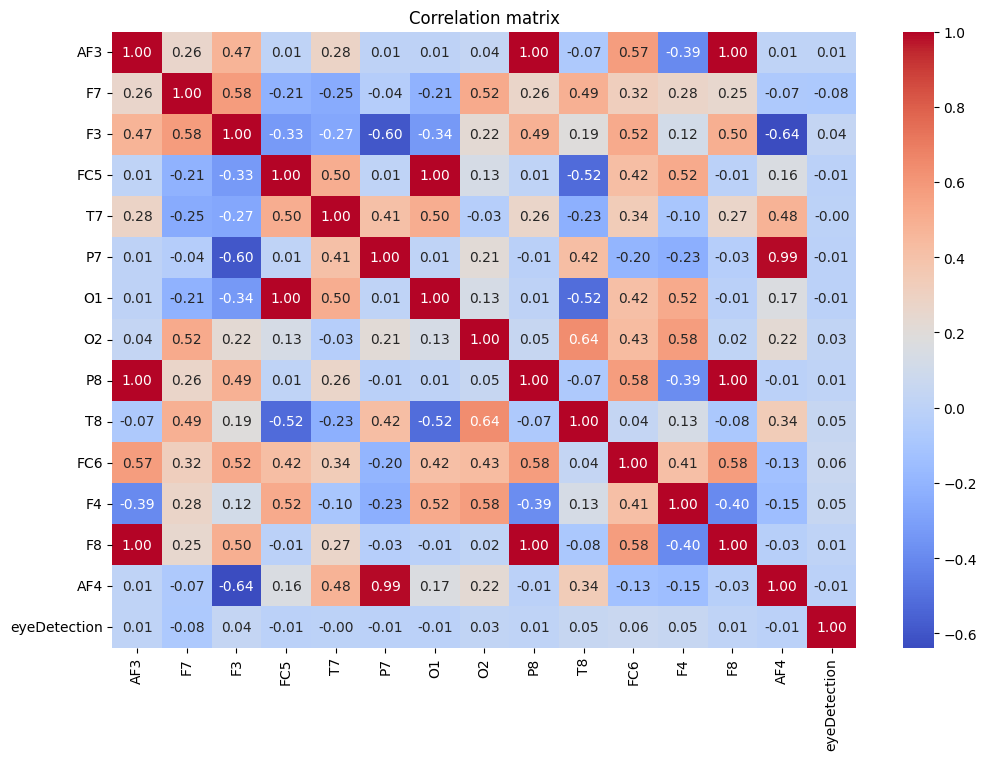

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), P8 i F8(1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [8]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [9]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [10]:
df.duplicated().any()

np.False_

In [11]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

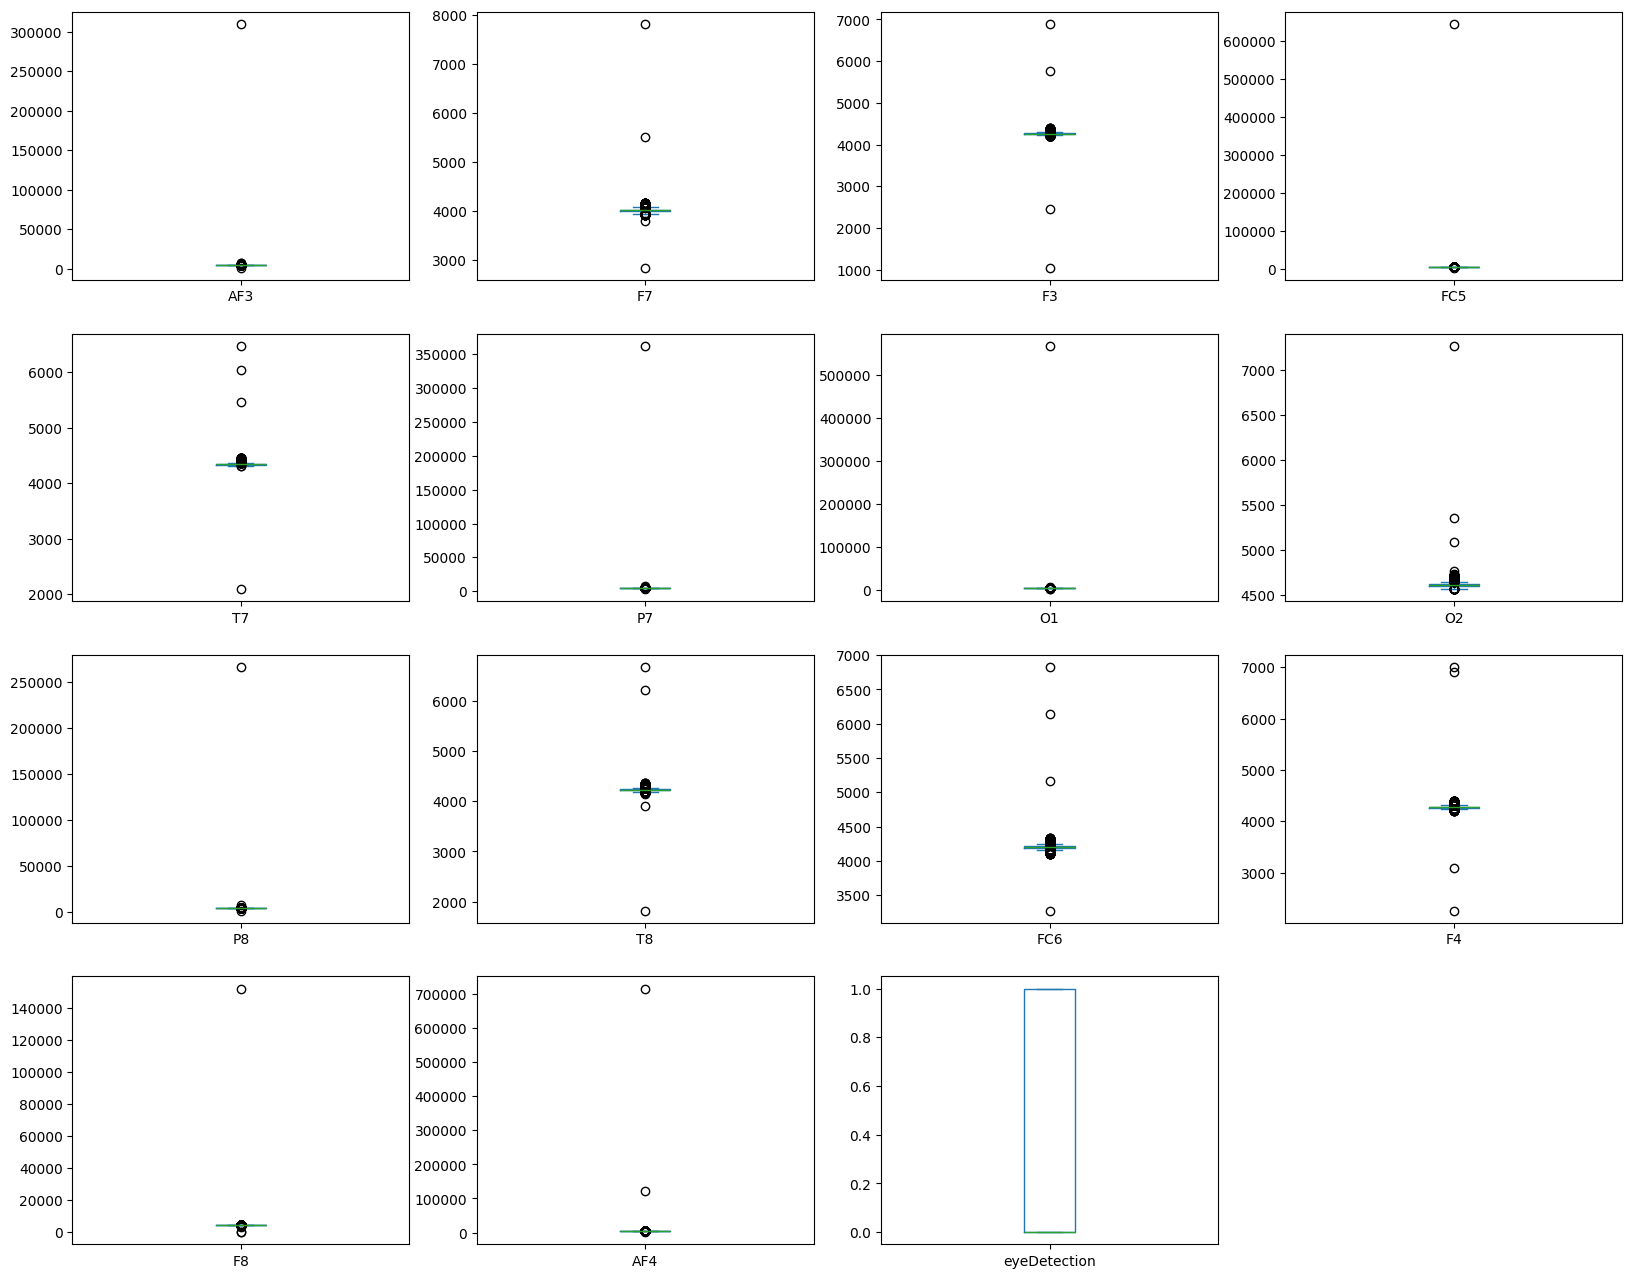

In [12]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

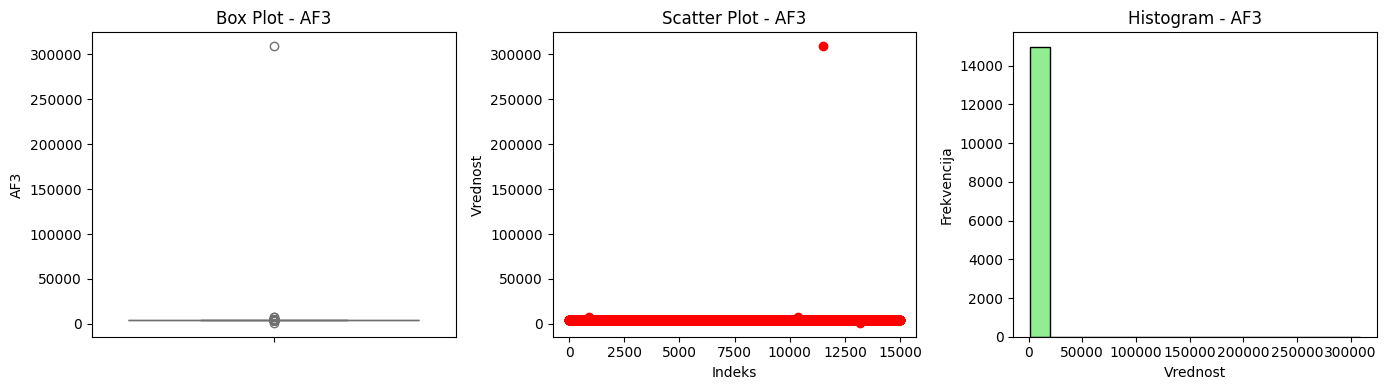

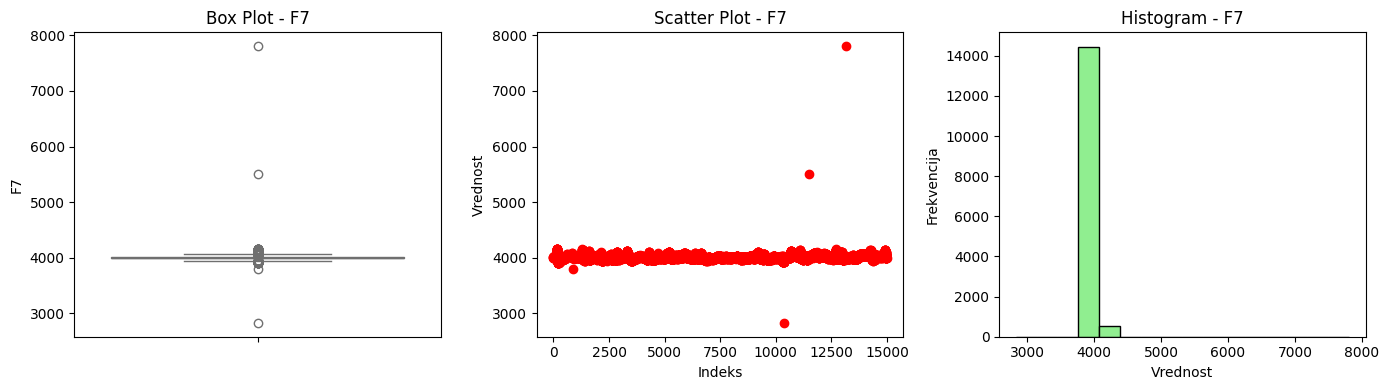

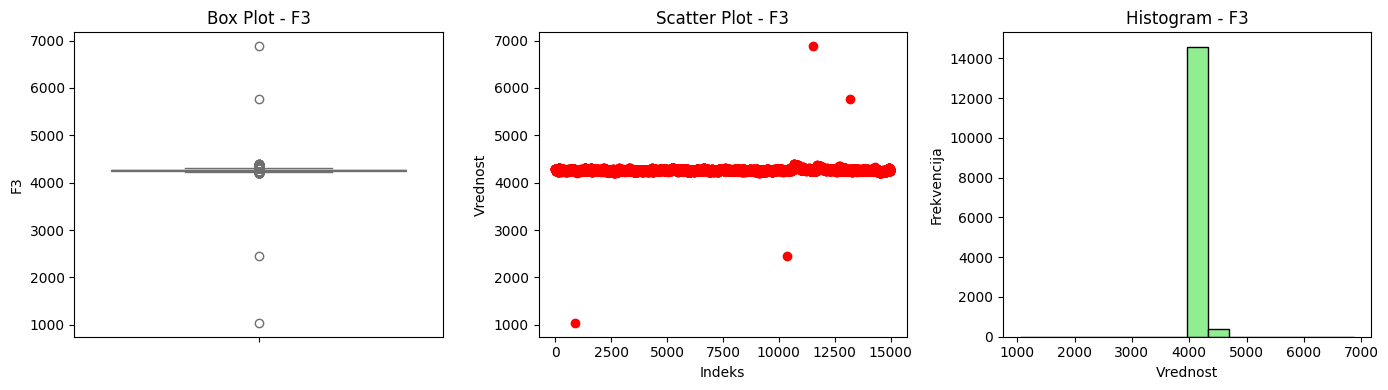

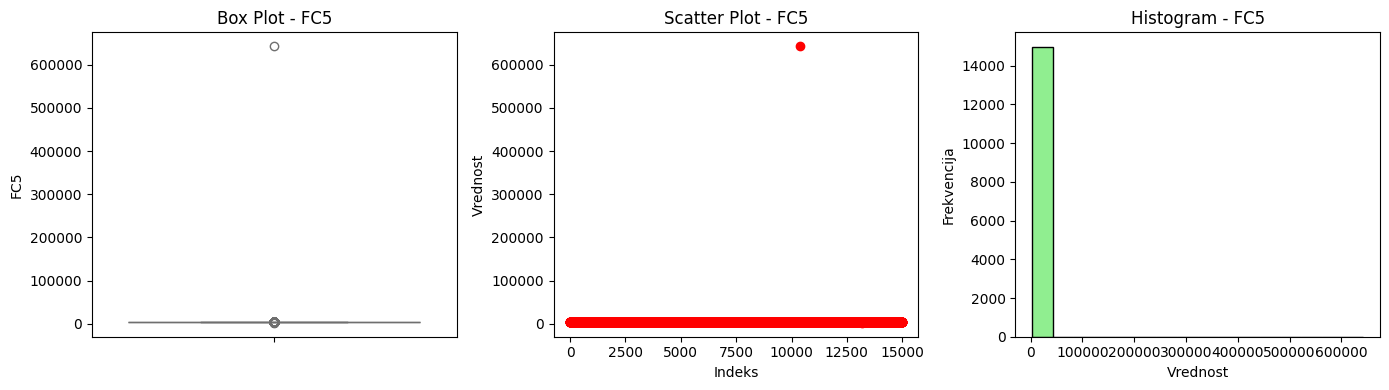

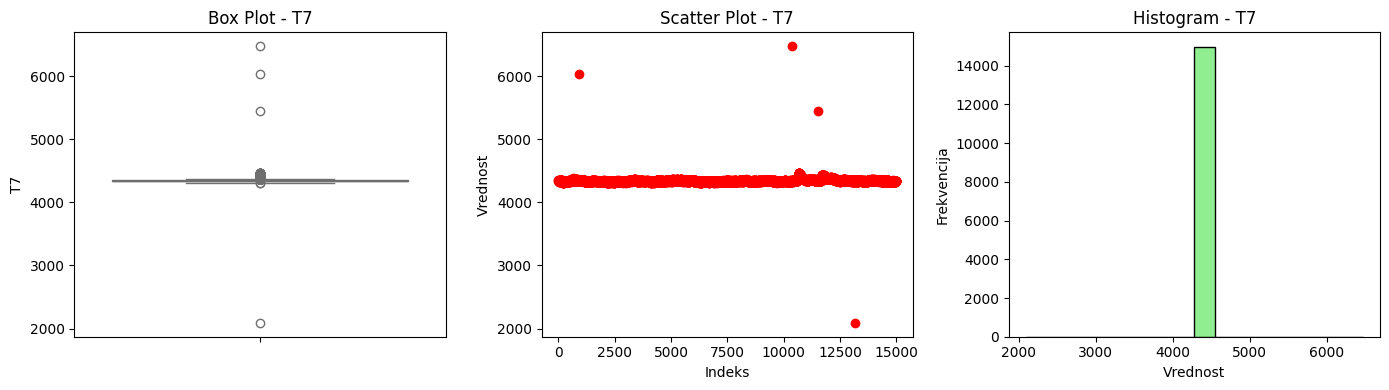

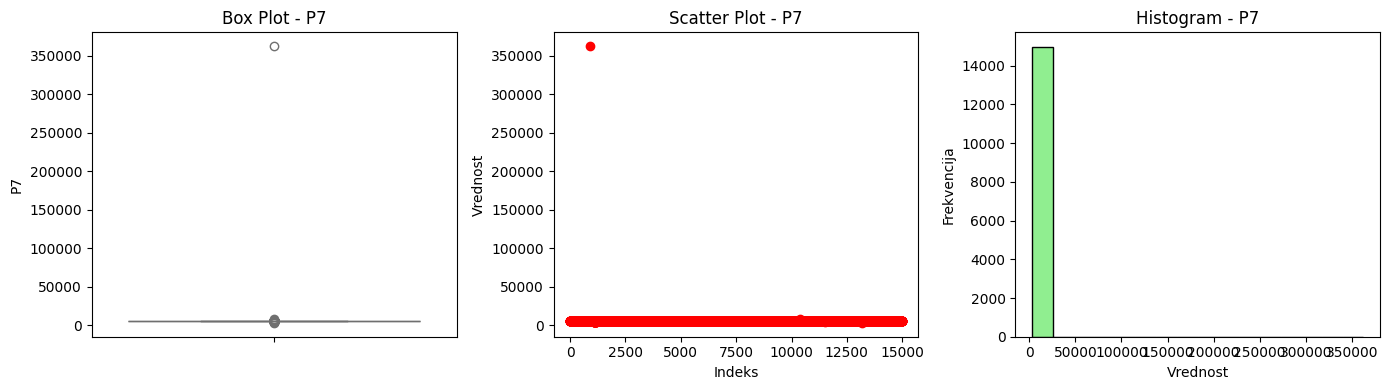

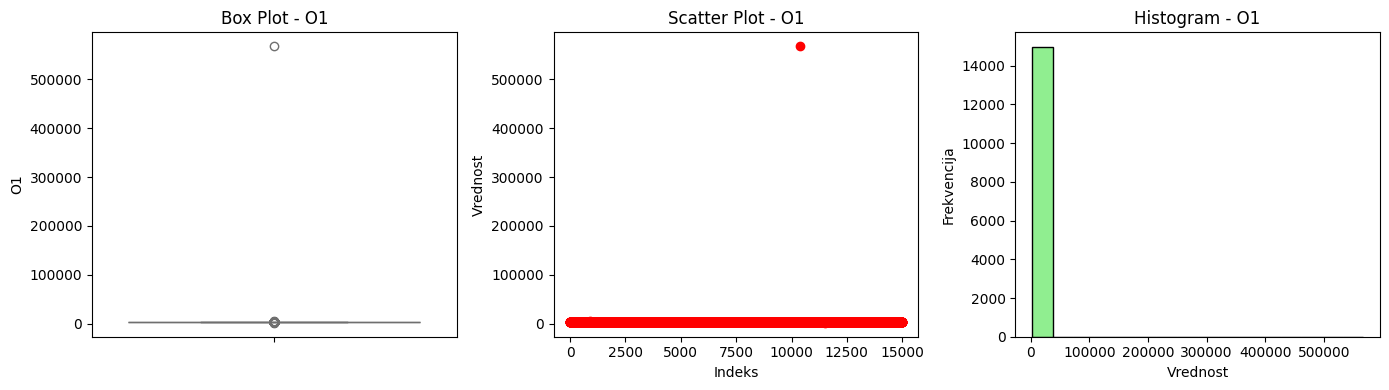

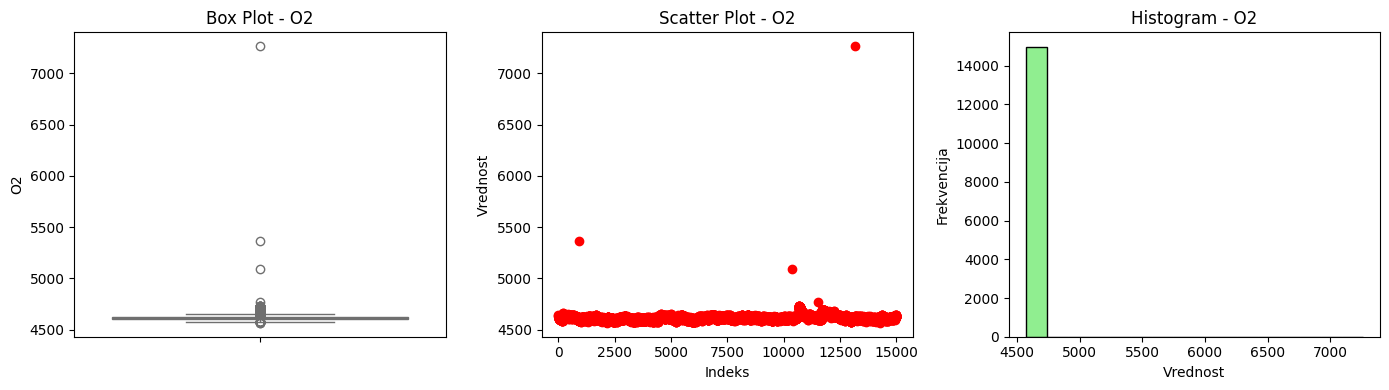

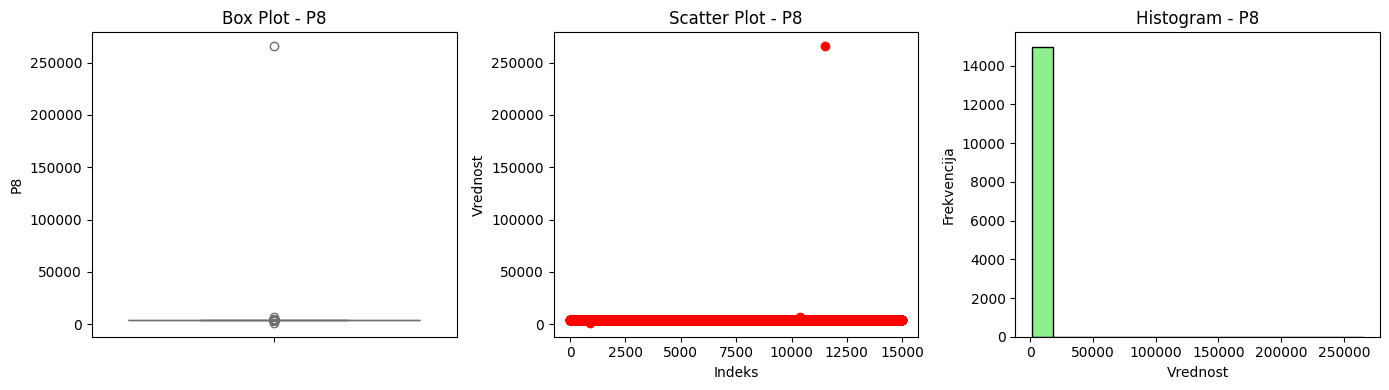

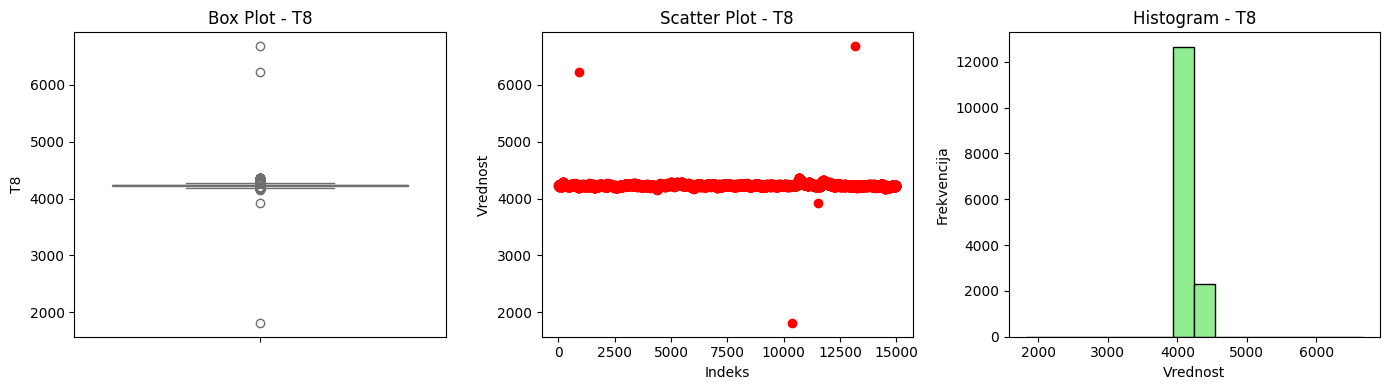

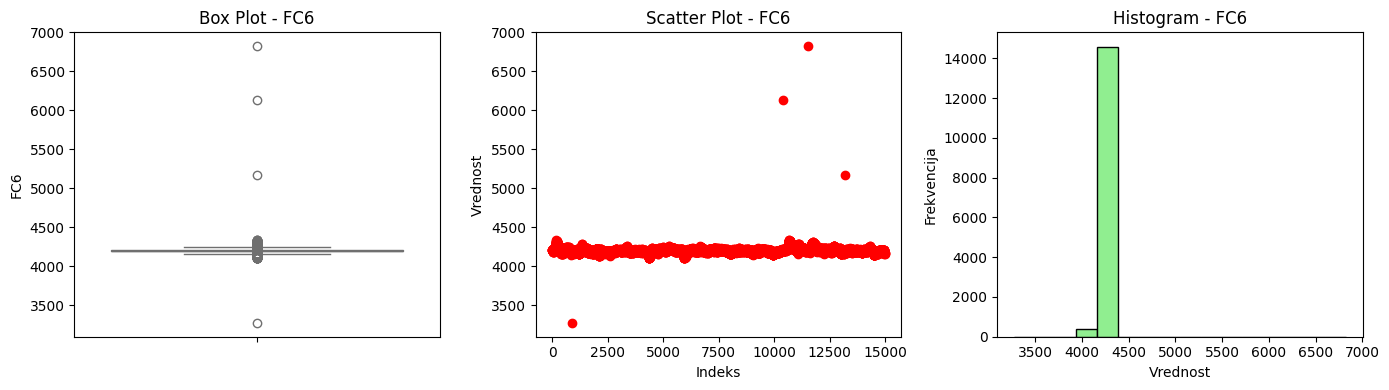

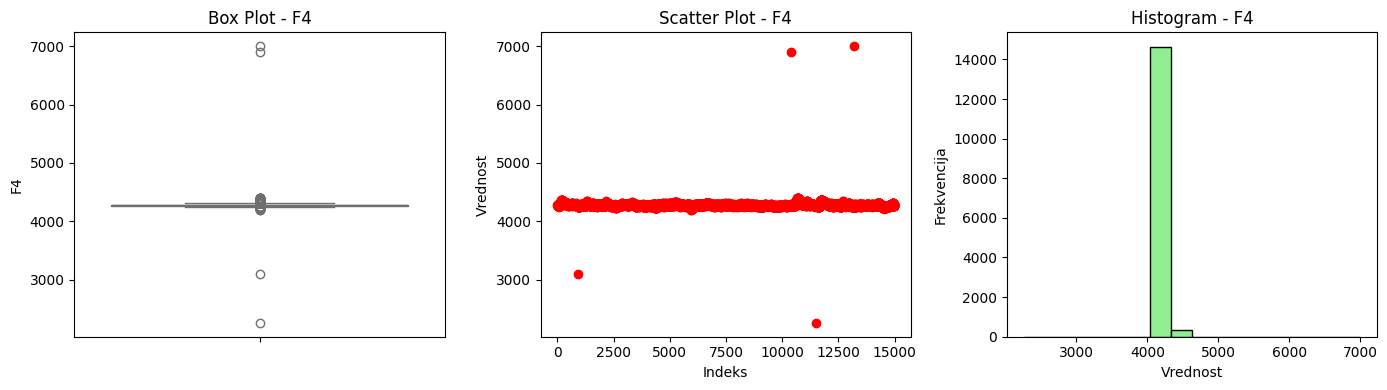

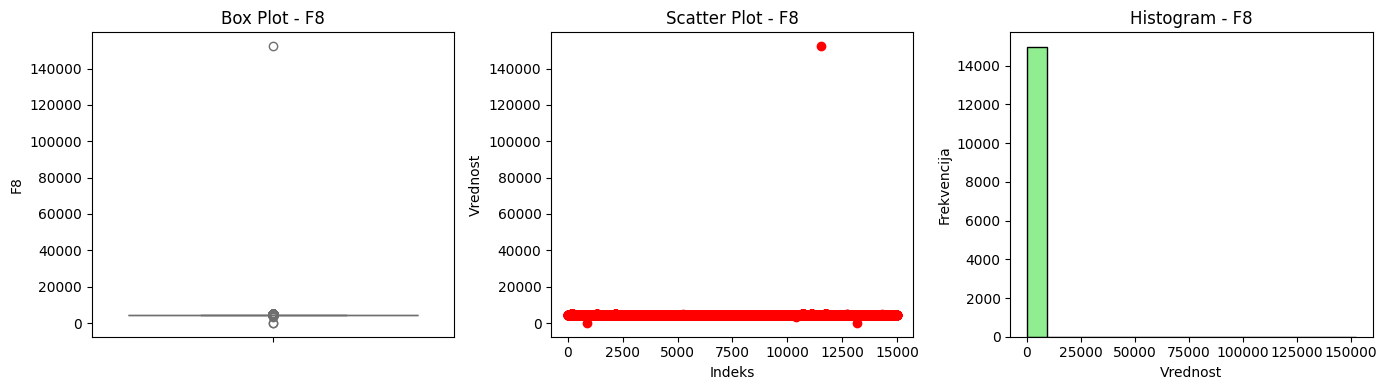

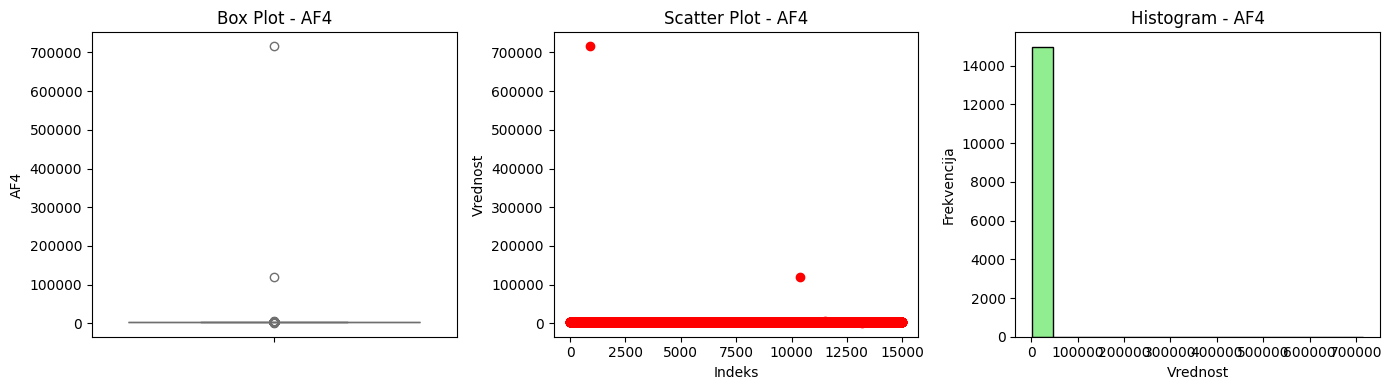

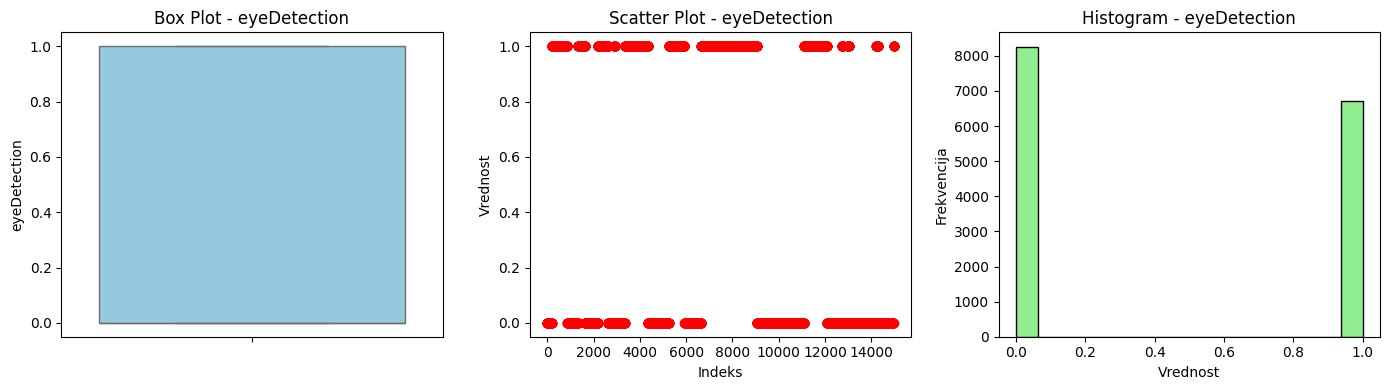

In [13]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [14]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [15]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 4. Treniranje modela

### Podela podataka:

In [16]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11984, 14)
(2996, 14)
(11984,)
(2996,)


### Lazy Predict

In [17]:
# from lazypredict.Supervised import LazyClassifier

# clf = LazyClassifier(
#     verbose=0, 
#     ignore_warnings=True, 
#     custom_metric=None, 
#     predictions=False,
# )

# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

Funkcija za izveštaj o performansama modela:

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np


def report(title=None, estimator=None, X=None, y=None, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        estimator.fit(X_train, y_train)
        y_pred_fold = estimator.predict(X_test)

        y_true_all.extend(list(y_test_fold))
        y_pred_all.extend(list(y_pred_fold))
        
    accuracy = accuracy_score(y_true_all, y_pred_all)

    return {
        "title": title,
        "accuracy": float(accuracy),
        "classification_report": classification_report(y_true_all, y_pred_all, output_dict=True),
        "confusion_matrix": confusion_matrix(y_true_all, y_pred_all)
    }

    # return {
    #     "title": title,
    #     "accuracy": accuracy_score(y_test, y_pred),
    #     "classification_report": classification_report(y_test, y_pred, output_dict=True),
    #     "confusion_matrix": confusion_matrix(y_test, y_pred),
    # }

### Random Forest

In [20]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.pipeline import Pipeline

def run_random_forest_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    forest = RandomForestClassifier(random_state=42, n_jobs=1)
    
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", forest))

    pipe = Pipeline(steps)
        
    res = report(estimator=pipe, X=X, y=y, title="Random Forest CV", cv=cv)
    return res["accuracy"]

### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [24]:
from sklearn.ensemble import ExtraTreesClassifier


def run_extra_trees_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", et_classifier))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Extra Trees Classifier CV", cv=cv)
        
    return res["accuracy"]        

### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [23]:
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", KNeighborsClassifier()))

    pipe = Pipeline(steps)  

    res = report(estimator=pipe, X=X, y=y, title="K-Nearest Neighbour Classifier CV", cv=cv)
    return res["accuracy"]

### SVM

In [22]:
from os import pipe
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)))

    pipe = Pipeline(steps)

    res = report(estimator=pipe, X=X, y=y, title="SVM Classifier CV", cv=cv)  
    return res["accuracy"]

### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [25]:
from sklearn.linear_model import LogisticRegression
from xgboost import cv

def run_logistic_regression_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = LogisticRegression(
        n_jobs = 1, max_iter=1000, random_state=42
    )

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", clf))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Logistic Regression Classifier CV", cv=cv)
    return res["accuracy"]

### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [26]:
from sklearn.naive_bayes import GaussianNB

def run_naive_bayes_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", GaussianNB()))

    pipe = Pipeline(steps)

    res = report(estimator=pipe, X=X, y=y, title="Naive Bayes Classifier CV", cv=cv)
    return res["accuracy"]

### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [27]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(preprocessors=None, X=None, y=None, cv=None, sampler=None):
    clf = DecisionTreeClassifier(random_state=42)

    steps = []
    if preprocessors:
        steps.extend([(f"prep_{i}", p) for i, p in enumerate(preprocessors)])
    if sampler is not None:
        steps.append(("sampler", sampler))  # sampler ide pre modela
    steps.append(("model", clf))

    pipe = Pipeline(steps)
    res = report(estimator=pipe, X=X, y=y, title="Decision Tree Classifier CV", cv=cv)
        
    return res["accuracy"]

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

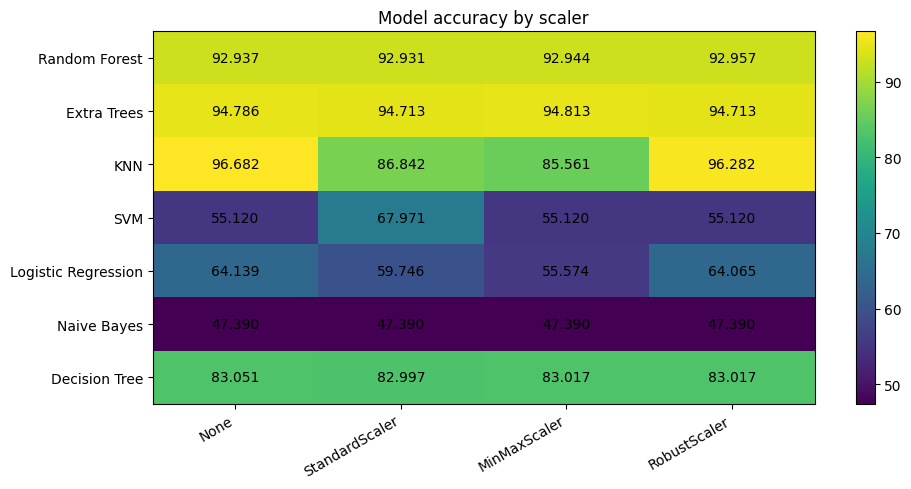

In [ ]:
def run_classifiers_matrix(X=None, y=None, scalers_dict=None, cv=None, sampler=None):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X=X, y=y, preprocessors=preprocessors, sampler=sampler, cv=cv) * 100
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],   
    "RobustScaler": [RobustScaler()],
}

acc_matrix_baseline = run_classifiers_matrix(
    X=X, y=y,  
    scalers_dict=scalers,
    cv=5    
)
plot_matrix_heatmap(acc_matrix_baseline, title="Model accuracy by scaler")


Zaključci:
KNN bez standardizacije daje najbolje rezultate.
Nakon njega je Extra Trees koji najbolje rezultate daje sa MinMax skalarom.

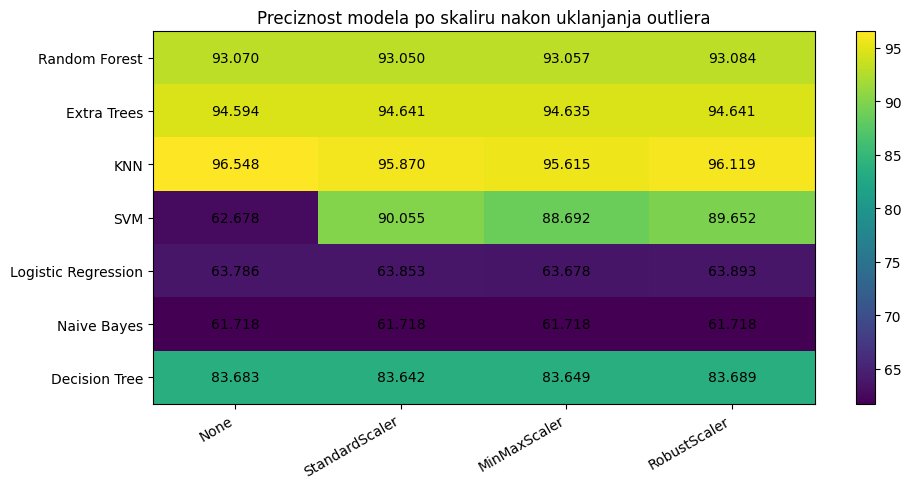

In [ ]:
df_no_outliers = df[~zscore_mask]

y_no_outliers = df_no_outliers['eyeDetection']

X_no_outliers = df_no_outliers.drop(
    ['eyeDetection'],
    axis=1
)

scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix_no_outliers = run_classifiers_matrix(X=X_no_outliers, y=y_no_outliers, scalers_dict=scalers, cv=5)
plot_matrix_heatmap(acc_matrix_no_outliers, title="Preciznost modela po skaliru nakon uklanjanja outliera")

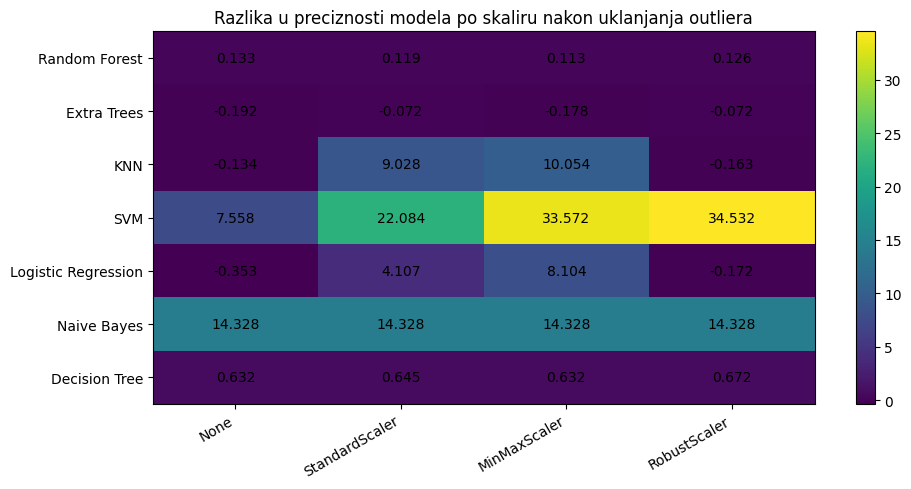

In [ ]:
plot_matrix_heatmap(acc_matrix_no_outliers - acc_matrix_baseline, title="Razlika u preciznosti modela po skaliru nakon uklanjanja outliera")

Uklanjanje outlier-a nije dovelo do poboljšanja preciznosti najboljih modela. KNN sa outlier-ima daje najbolje rezultate, kao i Extra Trees sa MinMax Skalarom.

Iz matrice se može videti da je uglavnom došlo do poboljšanja preciznosti većine modela. Preciznost kod Decision Tree i KNN je opala.

### Balansiranje

S obzirom da uklanjanje outlier-a nije dovelo do poboljšanja preciznosti, zadržaćemo dataset sa outlier-ima. Ovo može da ima smisla jer fičeri predstavljaju signale.

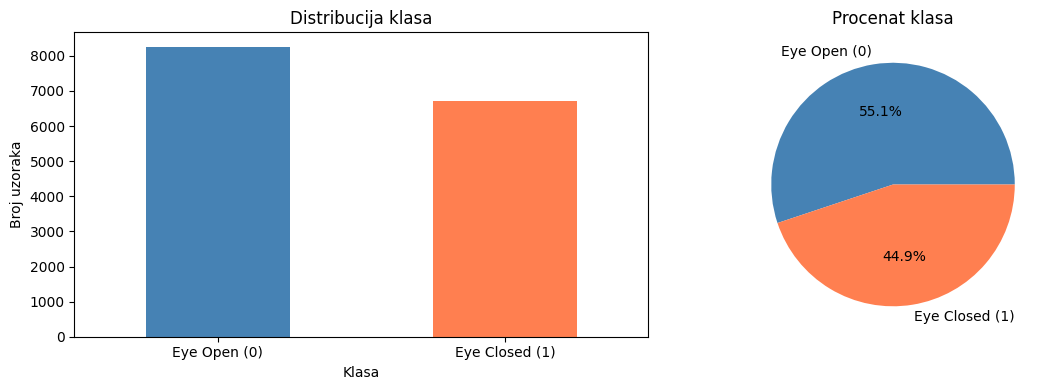

Imbalance ratio: 1.23:1


In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

y.value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
ax[0].set_title('Distribucija klasa')
ax[0].set_xlabel('Klasa')
ax[0].set_ylabel('Broj uzoraka')
ax[0].set_xticklabels(['Eye Open (0)', 'Eye Closed (1)'], rotation=0)

y.value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         labels=['Eye Open (0)', 'Eye Closed (1)'],
                                         colors=['steelblue', 'coral'])
ax[1].set_title('Procenat klasa')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

imbalance_ratio = y.value_counts().max() / y.value_counts().min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

#### Metode balansiranja

Isprobane su sledeće metode balansiranja:

1. **Random Oversampling** - duplikacija manjinske klase
2. **Random Undersampling** - smanjenje većinske klase
3. **SMOTE** - generisanje sintetičkih uzoraka manjinske klase
4. **ADASYN** - adaptivno generisanje sintetičkih uzoraka
5. **SMOTETomek** - kombinacija SMOTE i Tomek links
6. **SMOTEENN** - kombinacija SMOTE i Edited Nearest Neighbours

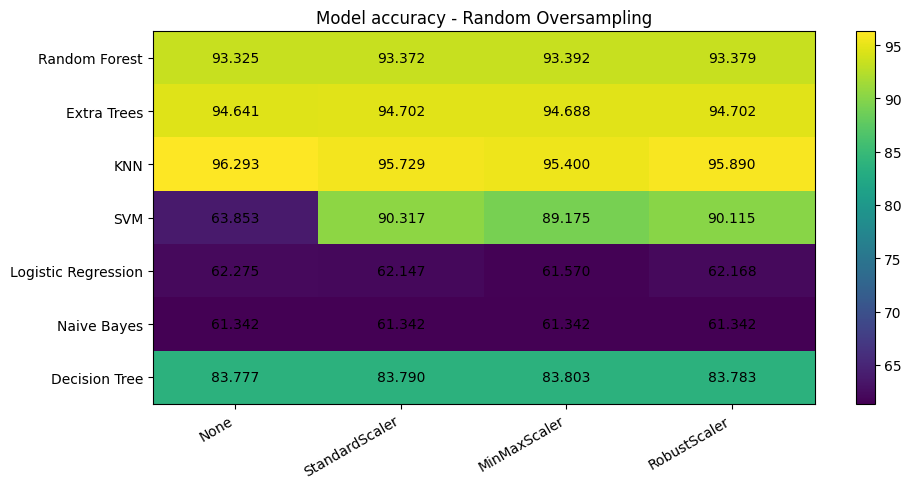

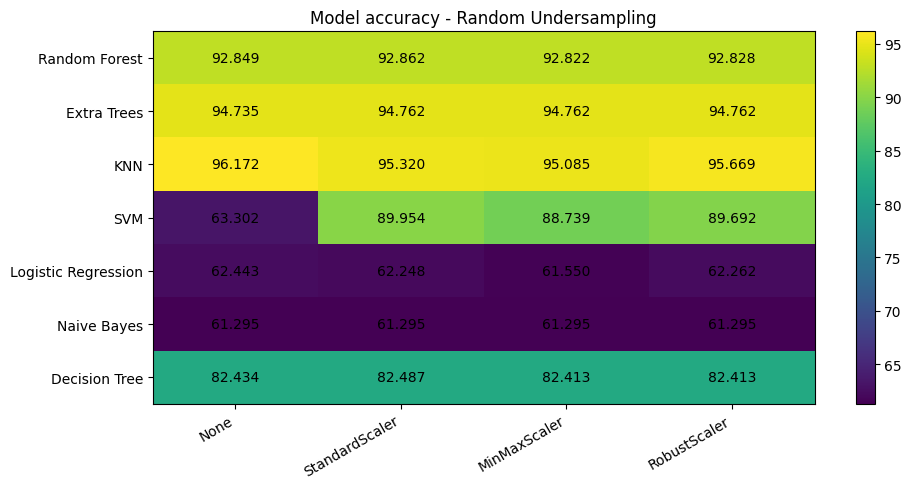

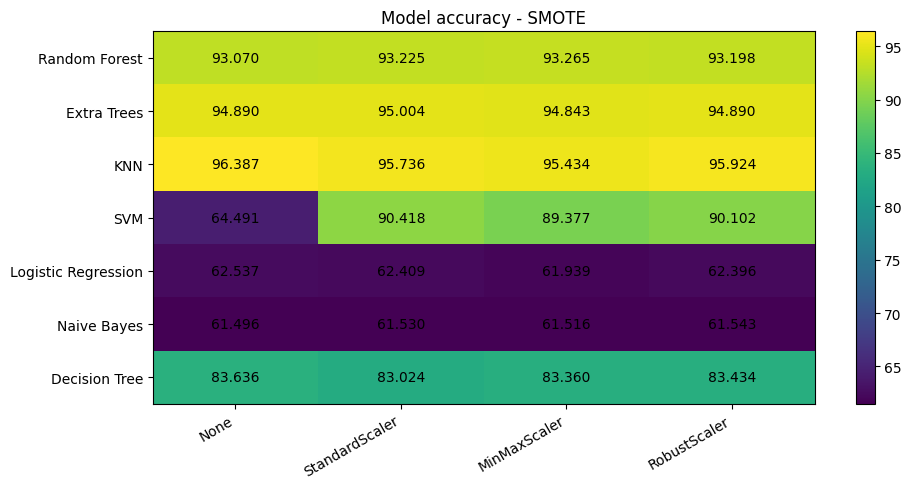

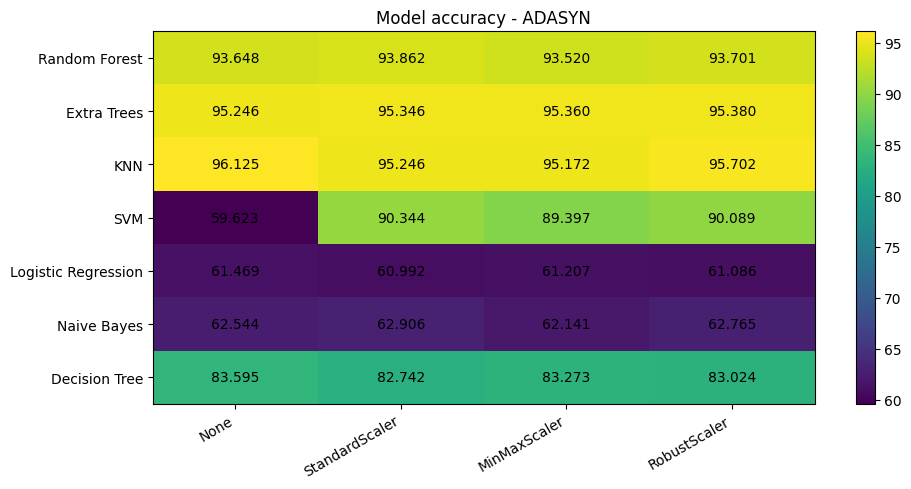

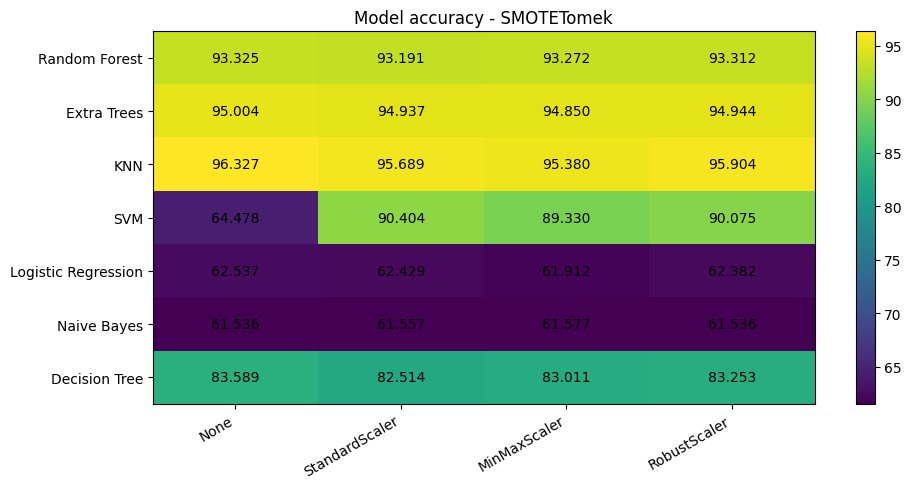

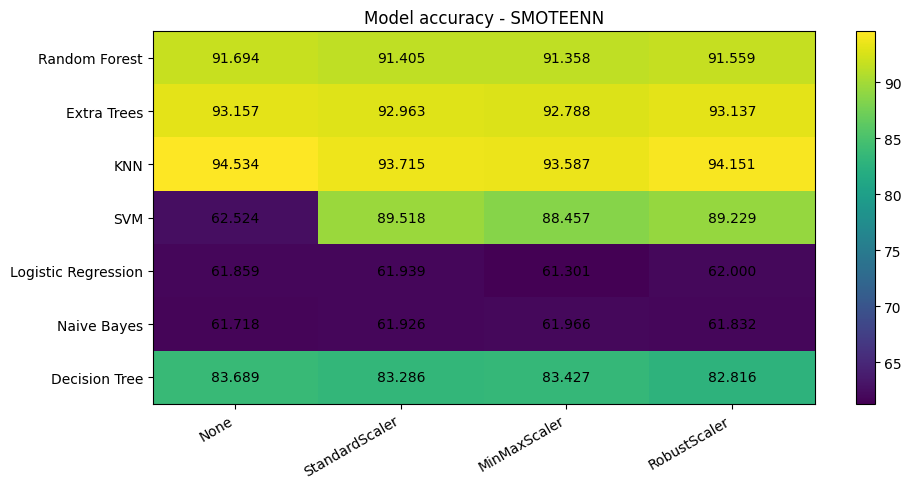

In [39]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

def evaluate_balancing_methods(X=None, y=None, cv=None):
    balancing_methods = {
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }
    
    results = []
    balanced_datasets = {}
    
    for method_name, sampler in balancing_methods.items():
        balanced_datasets[method_name] = (X, y)
            
        res = run_classifiers_matrix(
                X=X,
                y=y,
                scalers_dict=scalers,
                sampler=sampler,  # sampler ide u pipeline
                cv=cv
        )
            
        plot_matrix_heatmap(res, title="Model accuracy - " + method_name)
        results.append({
            "Balancing Method": method_name,
            "Accuracy Matrix": res
        })
    
    return pd.DataFrame(results), balanced_datasets

balancing_results, balanced_datasets = evaluate_balancing_methods(
    X=X_no_outliers,
    y=y_no_outliers,
    cv=5  # broj fold-ova
)


Možemo uočiti da ni jedan metod ne poboljšava preciznost i KNN i Extra Trees klasifikatora, pa nećemo primeniti balansiranje.

### Uklanjanje visoko korelisanih feature-a

Na osnovu ranije analize korelacije, uklanjamo redundantne feature-e koji imaju korelaciju > 0.95.

In [51]:
def run_extra_trees(X, y, cv):
    return run_extra_trees_classifier([MinMaxScaler()], X, y, cv) * 100

def run_knn(X, y, cv):
    return run_knn_classifier([], X, y, cv) * 100

In [ ]:
import itertools
import numpy as np
import pandas as pd

def get_high_corr_pairs(df: pd.DataFrame, threshold: float = 0.9):
    corr = df.corr().abs()
    cols = list(corr.columns)

    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            v = corr.iloc[i, j]
            if v > threshold:
                pairs.append((cols[i], cols[j], float(v)))
    return pairs

def evaluate_hight_corr_drops2(X, y, pairs, max_drop=5, cv=5):
    all_corr_cols = set()
    for col_a, col_b, _ in pairs:
        all_corr_cols.add(col_a)
        all_corr_cols.add(col_b)
    
    all_corr_cols = list(all_corr_cols)
    
    knn_results = []
    xtra_trees_results = []
    
    for num_to_drop in range(1, min(max_drop + 1, len(all_corr_cols) + 1)):
        combinations = itertools.combinations(all_corr_cols, num_to_drop)
        
        for drop_set in combinations:
            drop_set = list(drop_set)
            X_reduced = X.drop(columns=drop_set)

            knn_result = run_knn(X_reduced, y, cv)
            knn_results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Accuracy (%)": knn_result,
                "Remaining Features": X_reduced.shape[1],
            })

            xtra_trees_result = run_extra_trees(X_reduced, y, cv)
            xtra_trees_results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Accuracy (%)": xtra_trees_result,
                "Remaining Features": X_reduced.shape[1],
            })
    
    knn_results_df = pd.DataFrame(knn_results)
    knn_results_df = knn_results_df.sort_values(by="Accuracy (%)", ascending=False)
    
    xtra_trees_results_df = pd.DataFrame(xtra_trees_results)
    xtra_trees_results_df = xtra_trees_results_df.sort_values(by="Accuracy (%)", ascending=False)

    print("KNN")
    print(f"\nUkupno varijanti: {len(knn_results_df)}")
    print("\nTop 10 najboljih kombinacija:")
    print(knn_results_df.head(10).to_string(index=False))

    print("Extra Trees")
    print(f"\nUkupno varijanti: {len(xtra_trees_results_df)}")
    print("\nTop 10 najboljih kombinacija:")
    print(xtra_trees_results_df.head(10).to_string(index=False))

pairs = get_high_corr_pairs(X, threshold=0.95)
evaluate_hight_corr_drops2(X, y, pairs, 5)

KNN

Ukupno varijanti: 119

Top 10 najboljih kombinacija:
Dropped Columns  Num Dropped  Accuracy (%)  Remaining Features
           [P8]            1     96.755674                  13
      [P8, AF4]            2     96.428571                  12
      [FC5, P8]            2     96.368491                  12
          [AF4]            1     96.234980                  13
      [P8, AF3]            2     96.221629                  12
          [FC5]            1     96.148198                  13
       [P8, P7]            2     96.081442                  12
           [P7]            1     96.068091                  13
       [P8, F8]            2     96.028037                  12
          [AF3]            1     95.974633                  13
Extra Trees

Ukupno varijanti: 119

Top 10 najboljih kombinacija:
Dropped Columns  Num Dropped  Accuracy (%)  Remaining Features
           [P8]            1     94.933244                  13
       [P8, P7]            2     94.706275               

Može se primetiti da bi izbacivanje kolone P8 poboljšalo rezultate i KNN i Xtra Trees algoritma, pa ćemo tu kolonu izbaciti jer je visoko korelisana sa AF3 i F8.

In [52]:
X_no_P8 = X.drop(columns=['P8'])

### Redukcija dimenzionalnosti (PCA)

Primenjujemo PCA (Principal Component Analysis) za redukciju dimenzionalnosti sa zadržavanjem 95% varijanse.

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

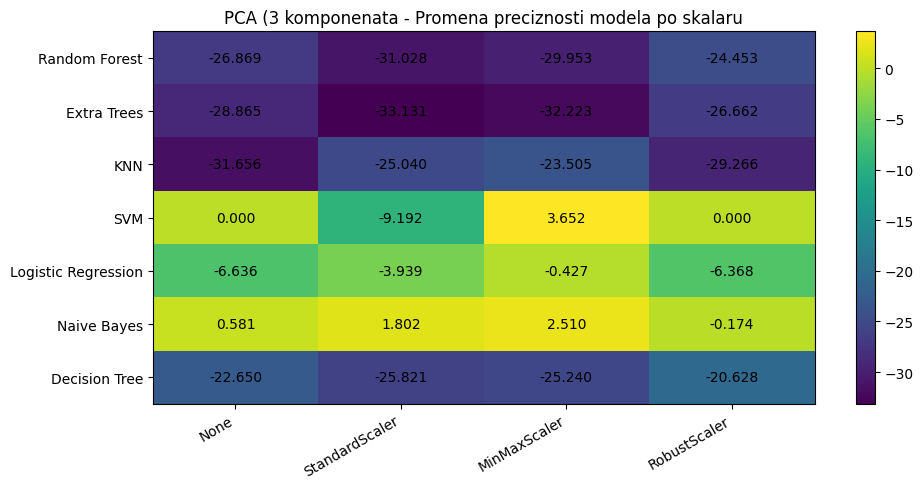

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

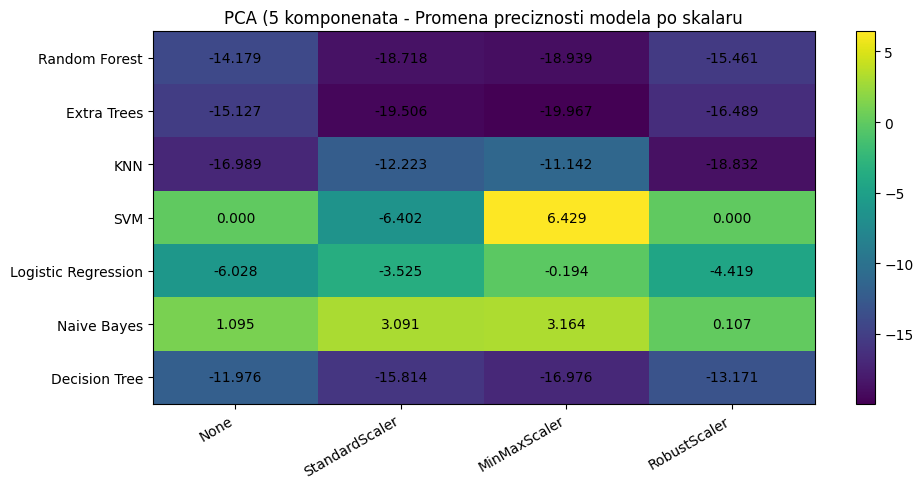

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

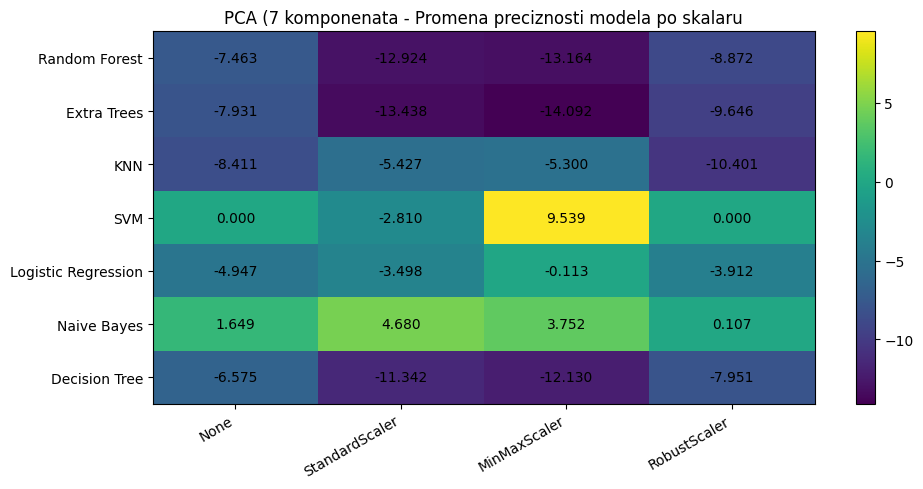

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

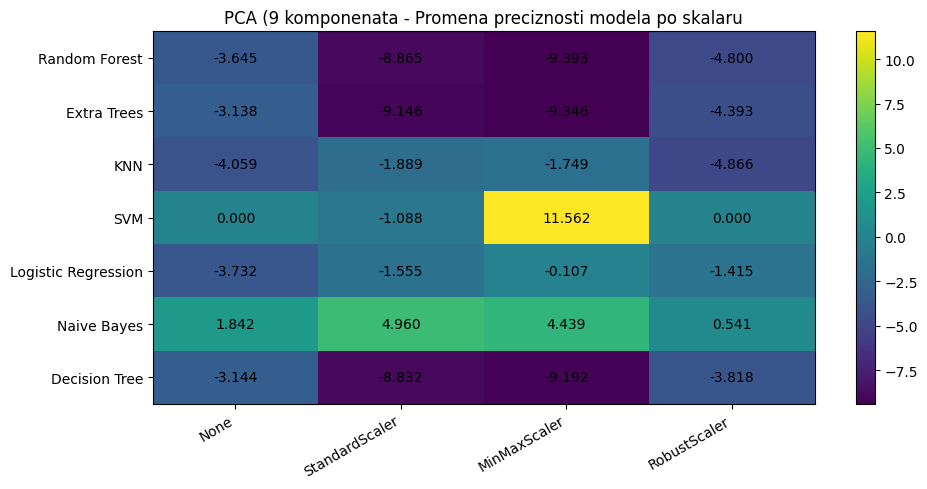

/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

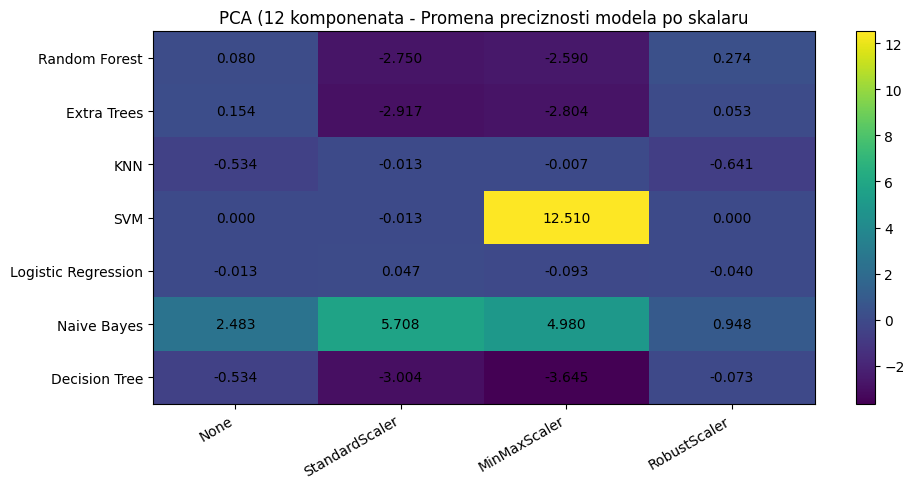

In [54]:
pca_results = []

for n_components in [3, 5, 7, 9, 12]:
    pca = PCA(n_components=n_components)

    scalers_with_pca = {
        scaler_name: (preprocessors + [PCA(n_components=n_components, random_state=42)])
        for scaler_name, preprocessors in scalers.items()
    }

    res = run_classifiers_matrix(X=X_no_P8, y=y, scalers_dict=scalers_with_pca, cv=5)
    plot_matrix_heatmap(res - run_classifiers_matrix(X=X_no_P8, y=y, scalers_dict=scalers, cv=5), title=f"PCA ({n_components} komponenata - Promena preciznosti modela po skalaru")

    pca_results.append({
        "n_components": n_components,
        "accuracy": res
    })

### Optimizacija hiperparametara

In [58]:
X_train_no_P8, X_test_no_P8, y_train_no_P8, y_test_no_P8 = train_test_split(
    X_no_P8, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [61]:
# Extra Trees optimizacija
print("\n--- Extra Trees optimizacija ---")
et_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

et = ExtraTreesClassifier(random_state=42, n_jobs=1)
et_grid = RandomizedSearchCV(et, et_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=1, verbose=1)
et_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {et_grid.best_params_}")
print(f"Najbolja CV tačnost: {et_grid.best_score_*100:.2f}%")

extra_trees_best = et_grid.best_estimator_


--- Extra Trees optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Najbolja CV tačnost: 94.63%


In [60]:
# KNN optimizacija
print("\n--- KNN optimizacija ---")
knn_param_grid = {
    'n_neighbors': range(1, 300, 2) ,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_grid = RandomizedSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=1, verbose=1)
knn_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {knn_grid.best_params_}")
print(f"Najbolja CV tačnost: {knn_grid.best_score_*100:.2f}%")

knn_best = knn_grid.best_estimator_


--- KNN optimizacija ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Najbolji parametri: {'weights': 'distance', 'n_neighbors': 57, 'metric': 'euclidean'}
Najbolja CV tačnost: 90.88%



Rezultati nakon optimizacije hiperparametara
              Model  Accuracy (%)  F1-Score (%)         Step
Random Forest (opt)         93.22         93.21 Optimizovano
  Extra Trees (opt)         94.86         94.85 Optimizovano
          KNN (opt)         91.22         91.21 Optimizovano
          SVM (opt)         83.44         83.27 Optimizovano


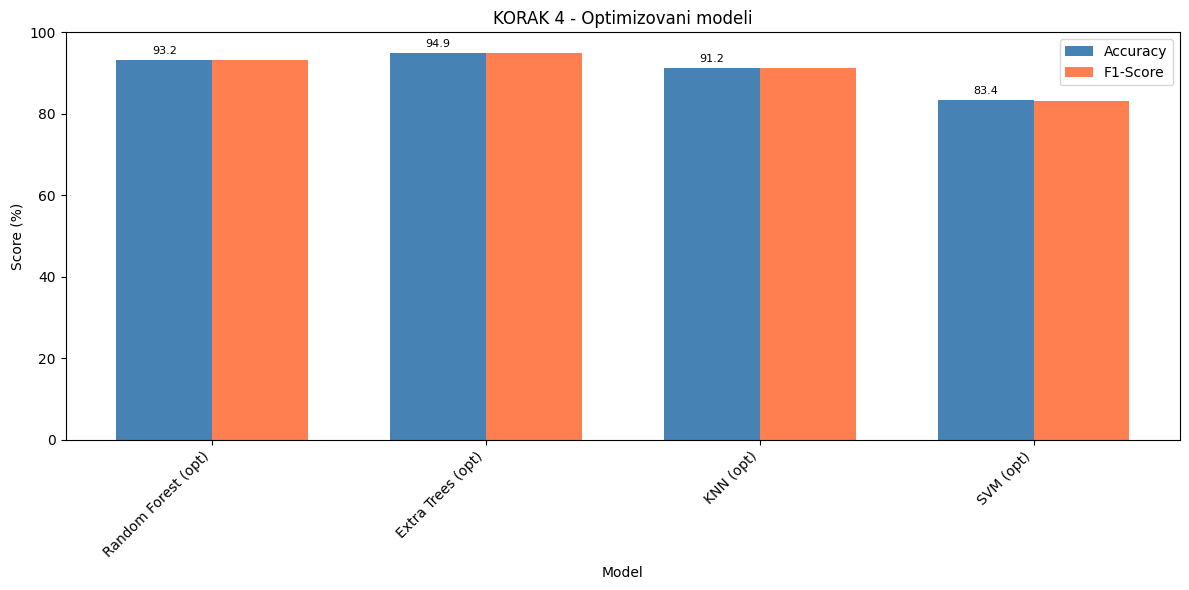

In [ ]:
# Sumarni rezultati nakon optimizacije hiperparametara
print("\n" + "=" * 60)
print("Rezultati nakon optimizacije hiperparametara")
print("=" * 60)

optimized_results = pd.DataFrame([
    {"Model": "Extra Trees (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, et_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, et_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "KNN (opt)", "Accuracy (%)": round(accuracy_score(y_test_no_P8, knn_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test_no_P8, knn_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
])

print(optimized_results.to_string(index=False))
plot_comparison(optimized_results, "KORAK 4 - Optimizovani modeli")

all_results.append(optimized_results.copy())

## 6. Analiza interpretabilnosti modela

U ovom delu analiziramo interpretabilnost modela koristeći:
- **Feature Importance** - značaj feature-a u tree-based modelima
- **SHAP vrednosti** - SHapley Additive exPlanations
- **LIME** - Local Interpretable Model-agnostic Explanations

### 6.1 Feature Importance (Random Forest & Extra Trees)

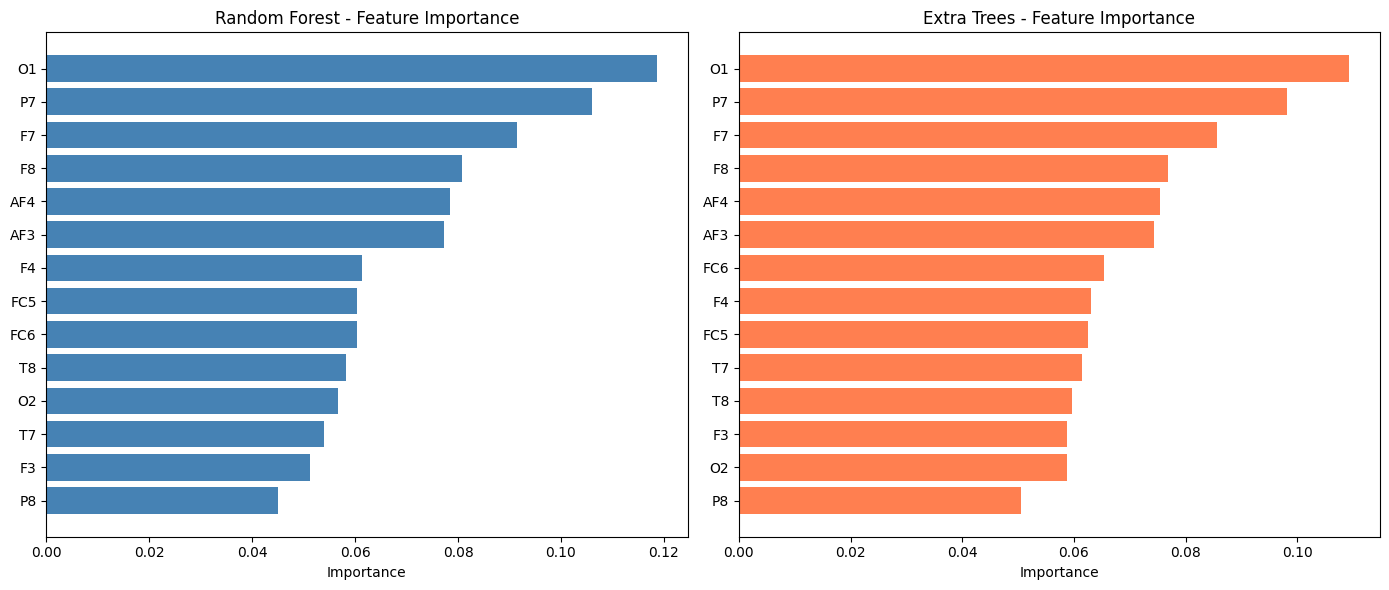


Top 5 najvažnijih feature-a (Random Forest):
Feature  Importance
     O1    0.118659
     P7    0.106063
     F7    0.091444
     F8    0.080860
    AF4    0.078503

Top 5 najvažnijih feature-a (Extra Trees):
Feature  Importance
     O1    0.109358
     P7    0.098150
     F7    0.085555
     F8    0.076801
    AF4    0.075481


In [ ]:
# Feature Importance analiza
feature_names = X.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Extra Trees Feature Importance
et_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].invert_yaxis()

# Extra Trees
axes[1].barh(et_importance['Feature'], et_importance['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Extra Trees - Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 najvažnijih feature-a (Random Forest):")
print(rf_importance.head().to_string(index=False))
print("\nTop 5 najvažnijih feature-a (Extra Trees):")
print(et_importance.head().to_string(index=False))

### SHAP Analiza (SHapley Additive exPlanations)

SHAP vrednosti pokazuju doprinos svakog feature-a predikciji modela.

### LIME Analiza (Local Interpretable Model-agnostic Explanations)

LIME objašnjava pojedinačne predikcije kreirajući lokalni interpretabilan model.